# Fast training with MONAI features

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes:
1. AMP (Auto mixed precision).
2. CacheDataset for deterministic transforms.
3. Move data to GPU and cache, then execute random transforms on GPU.
4. Disable meta tracking in the random transforms to avoid unnecessary computation.
5. multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight task.
6. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
7. Analyzed training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

With a V100 GPU and the target validation `mean dice = 0.94` of the `forground` channel only,  it's more than `100x` speedup compared with the Pytorch regular implementation when achieving the same metric. And every epoch is `20x` faster than regular training.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/acceleration/fast_training_tutorial.ipynb)(* please note that the free GPU resource in Colab may be not as powerful as the V100 test results in this notebook: it may not support AMP and the GPU computation of transforms may be not faster than the CPU computation.)

## Setup environment

This cell verifies that you have key packages installed and sets up the matplotlib environment.

Important: if you are interested in profiling, comment out this cell after you finish the checks.

In [ ]:
# if profiling, comment out this cell to ensure the converted python script runs smoothly

!python3 -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python3 -c "import matplotlib" || pip install -q matplotlib
!python3 -c "import nvtx" || pip install -q nvtx

%matplotlib inline

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import set_determinism

# for profiling
import nvtx
from monai.utils.nvtx import Range
import contextlib  # to improve code readability (combining training/validation loop with and without profiling)

print_config()

## Setup data & output directories

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


By default, outputs will go to `outputs/`. 

You can run this tutorial twice, once with profiling and once without, and the outputs will not conflict with each other. 
- When profiling, the output is `outputs/output_base.nsys-rep`, which you can then visualize using the GUI of Nsight systems (a brief guide is provided in the "Profiling visualization" section below).
- When not profiling, the outputs are `outputs/loss_dice_comparison.png`, `outputs/metric_time_epochs.png`, and `outputs/total_epoch_time_comparison.png`.

We set up the tutorial such that figures are only generated when not profiling, but that does not have to be the case. In general, the figures make more sense when training is run for a higher number of epochs (e.g., hundreds), which is usually not the case when profiling.

In [3]:
# outputs

out_dir = "outputs/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Profiling

This section sets up profiling for this tutorial.

The number of epochs is automatically set based on whether profiling is being performed, but you can modify as needed.

- If you are not interested in profiling, please set `profiling = False` and move on.

- If you are profiling:

  - Because of the currently supported functionality of Nsight systems (`nsys`), profiling can only be performed from the terminal, and not from within this tutorial. For more information, including installation, refer to the [NVIDIA Nsight Systems page](https://developer.nvidia.com/nsight-systems).
  - Perform the following steps:
  
    1) Make sure `nsys` is installed;
    
    2) Set `profiling = True`;
    
    3) Make sure all lines in "Setup environment" (first code cell in this tutorial, above) are commented out;
    
    4) Save this notebook;
    
    5) Open the terminal and ensure that you are in the directory of this notebook, then run this command:
    `jupyter nbconvert fast_training_tutorial.ipynb --to python && nsys profile --output ./outputs/output_base --force-overwrite true --trace-fork-before-exec true python3 fast_training_tutorial.py ; rm fast_training_tutorial.py`
    
    This command converts the notebook to a Python script locally and runs `nsys`. The output file is `outputs/output_base.nsys-rep`, but you can modify `--output` to specify the desired location.

In [4]:
profiling = False

# if profiling = True, it is recommended to set max_epochs = 6 for faster prototyping
# to see the trend in training curve and dice results, set max_epochs to be larger (600)
# note that before optimization, training can be quite a bit slower
if profiling:
    max_epochs = 6
else:
    max_epochs = 600

# to improve readability


def range_func(x, y): return Range(x)(y) if profiling else y


no_profiling = contextlib.nullcontext()

## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [7]:
def transformations(fast=False, device='cuda:0'):
    train_transforms = [
        range_func("LoadImage", LoadImaged(keys=["image", "label"])),
        range_func("EnsureChannelFirst", EnsureChannelFirstd(keys=["image", "label"])),
        range_func("Orientation", Orientationd(keys=["image", "label"], axcodes="RAS")),
        range_func("Spacing", Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        )),
        range_func("ScaleIntensityRange",
                   ScaleIntensityRanged(
                       keys=["image"],
                       a_min=-57,
                       a_max=164,
                       b_min=0.0,
                       b_max=1.0,
                       clip=True,
                   )),
        range_func("CropForeground", CropForegroundd(keys=["image", "label"], source_key="image")),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        range_func("Indexing", FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        )),
    ]

    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            range_func("EnsureType", EnsureTyped(keys=["image", "label"], device=device, track_meta=False))
        )

    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        range_func("RandCrop", RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        )),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            EnsureTyped(keys=["image", "label"], device=device, track_meta=False)
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.
2. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
3. `ToDeviced` transform: to move data to GPU and cache with `CacheDataset`, then execute random transforms on GPU directly, avoid CPU -> GPU sync in every epoch. Please note that not all the MONAI transforms support GPU operation so far, still working in progress.
4. `set_track_meta(False)`: to disable meta tracking in the random transforms to avoid unnecessary computation.
5. `ThreadDataLoader`: uses multi-threads instead of multi-processing, faster than `DataLoader` in light-weight task as we already cached the results of most computation.
6. `DiceCE` loss function: computes Dice loss and Cross Entropy Loss, returns the weighted sum of these two losses.
7. Analyzed the training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

(A note on code: to improve readability and support the profiling flag, we used the `with nvtx(...) if profiling else no_profiling` context pattern, where `no_profiling` is a null context from Python's native `contextlib` with no effect on the code. An acknowledgement is provided here[<sup id="fn1-back">1</sup>](#fn1).)

In [8]:
def train_process(fast=False):
    learning_rate = 2e-4
    val_interval = 5  # do validation for every epoch
    set_track_meta(True)

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        raise RuntimeError('this tutorial is intended for GPU, but no CUDA device is available')

    train_trans, val_trans = transformations(fast=fast, device=device)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5, copy_cache=False
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

        loss_function = DiceCELoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            squared_pred=True,
            batch=True,
            smooth_nr=0.00001,
            smooth_dr=0.00001,
            lambda_dice=0.5,
            lambda_ce=0.5,
        )
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
            kernel_size=3,
            up_kernel_size=3,
            act=Act.PRELU,
            dropout=0.2,
            bias=True,
        ).to(device)
        # avoid the computation of meta information in random transforms
        set_track_meta(False)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # profiling: full epoch
        with nvtx.annotate("epoch", color="red") if profiling else no_profiling:
            model.train()
            epoch_loss = 0
            train_loader_iterator = iter(train_loader)

            # using step instead of iterate through train_loader directly to track data loading time
            # steps are 1-indexed for printing and calculation purposes
            for step in range(1, len(train_loader) + 1):
                step_start = time.time()

                # profiling: train dataload
                with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                    # rng_train_dataload = nvtx.start_range(message="dataload", color="red")
                    batch_data = next(train_loader_iterator)
                    inputs, labels = (
                        batch_data["image"].to(device),
                        batch_data["label"].to(device),
                    )

                optimizer.zero_grad()
                # set AMP for MONAI training
                if fast:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        scaler.scale(loss).backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        scaler.step(optimizer)
                        scaler.update()
                else:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        loss.backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        optimizer.step()

                epoch_loss += loss.item()
                epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
                print(
                    f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                    f" step time: {(time.time() - step_start):.4f}"
                )
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loader_iterator = iter(val_loader)

                    for _ in range(len(val_loader)):
                        # profiling: val dataload
                        with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                            val_data = next(val_loader_iterator)
                            val_inputs, val_labels = (
                                val_data["image"].to(device),
                                val_data["label"].to(device),
                            )

                        roi_size = (160, 160, 160)
                        sw_batch_size = 4

                        # profiling: sliding window
                        with nvtx.annotate("sliding window", color="green") if profiling else no_profiling:
                            # set AMP for MONAI validation
                            if fast:
                                with torch.cuda.amp.autocast():
                                    val_outputs = sliding_window_inference(
                                        val_inputs, roi_size, sw_batch_size, model
                                    )
                            else:
                                val_outputs = sliding_window_inference(
                                    val_inputs, roi_size, sw_batch_size, model
                                )

                        # profiling: decollate batch
                        with nvtx.annotate("decollate batch", color="blue") if profiling else no_profiling:
                            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                            val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                        # profiling: compute metric
                        with nvtx.annotate("compute metric", color="yellow") if profiling else no_profiling:
                            dice_metric(y_pred=val_outputs, y=val_labels)

                    metric = dice_metric.aggregate().item()
                    dice_metric.reset()
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        best_metrics_epochs_and_time[0].append(best_metric)
                        best_metrics_epochs_and_time[1].append(best_metric_epoch)
                        best_metrics_epochs_and_time[2].append(
                            time.time() - total_start
                        )
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pt"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current"
                        f" mean dice: {metric:.4f}"
                        f" best mean dice: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )
        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

In [ ]:
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

## Enable determinism and execute MONAI optimized training

In [ ]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

## Profiling visualization

Here we give a brief overview of key observations from the `nsys-rep` output file when opened in Nsight systems (2022.2.1).

In the GUI, select File -> Open -> output_base.nsys-rep. Here is a sample of the display:

![png](figures/nsys-all-annotated.png)
- To get a better view of details, you can left-click and select a horizontal section, then right-click and "Zoom into Selection." To return, right-click and select "Reset Zoom."
- Sections B and C show training before and after acceleration (when fast=False and fast=True, accordingly). Clearly, MONAI optimized training is much faster than regular PyTorch training. B and C both contain two rows; the upper row shows per-epoch time, and the lower row shows per-action time (user-defined, like dataloading, forward, backward, etc.).
- Section A shows GPU utilization, where the height of the blue bars represents utilization rate. Regular PyTorch training shows sporadic and varying levels of GPU utilization, while MONAI optimized training shows consistent and high levels of GPU utilization.

Expanding one more thread in the lower left corner and several more threads below \[4648\], we see the following:

![png](figures/nsys-transforms-annotated.png)

Sections D and E both include information on the transform chain.
- Section E: In MONAI optimized training, results of all transforms in the chain until the first randomized transform is stored to prevent repeated operations. This explains why E is chronologically before any of the training epochs in the figure.
- Section D: In regular PyTorch training, CacheDataset is not in use, and the transform chain is performed every epoch on all data used.

Here is the display of the transform chain when zoomed in:
![png](figures/nsys-fast-transform.png)

And a display of one training epoch of MONAI optimized training when zoomed in:
![png](figures/nsys-epoch-short.png)

Notice that the per-epoch time is >20 times faster than the regular PyTorch training.

## Plot training loss and validation metrics

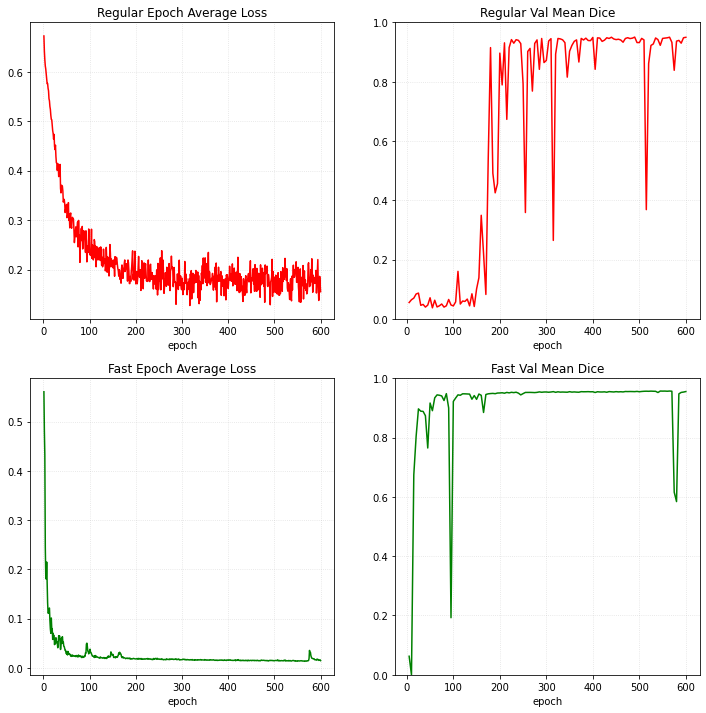

In [11]:
if not profiling:
    plt.figure("train", (12, 12))
    plt.subplot(2, 2, 1)
    plt.title("Regular Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="red")

    plt.subplot(2, 2, 2)
    plt.title("Regular Val Mean Dice")
    x = [(i + 1) * 5 for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.ylim(0, 1)
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="red")

    plt.subplot(2, 2, 3)
    plt.title("Fast Epoch Average Loss")
    x = [i + 1 for i in range(len(m_epoch_loss_values))]
    y = m_epoch_loss_values
    plt.xlabel("epoch")
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="green")

    plt.subplot(2, 2, 4)
    plt.title("Fast Val Mean Dice")
    x = [(i + 1) * 5 for i in range(len(m_metric_values))]
    y = m_metric_values
    plt.xlabel("epoch")
    plt.ylim(0, 1)
    plt.grid(alpha=0.4, linestyle=":")
    plt.plot(x, y, color="green")
    plt.savefig("outputs/loss_dice_comparison.png")

## Plot total time and every epoch time

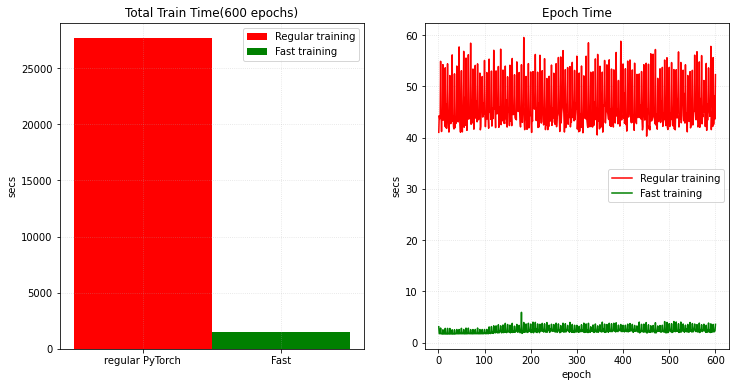

In [12]:
if not profiling:
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Total Train Time(600 epochs)")
    plt.bar(
        "regular PyTorch", total_time, 1, label="Regular training", color="red"
    )
    plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
    plt.ylabel("secs")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 2, 2)
    plt.title("Epoch Time")
    x = [i + 1 for i in range(len(epoch_times))]
    plt.xlabel("epoch")
    plt.ylabel("secs")
    plt.plot(x, epoch_times, label="Regular training", color="red")
    plt.plot(x, m_epoch_times, label="Fast training", color="green")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")
    plt.savefig("outputs/total_epoch_time_comparison.png")

## Plot total time to achieve metrics

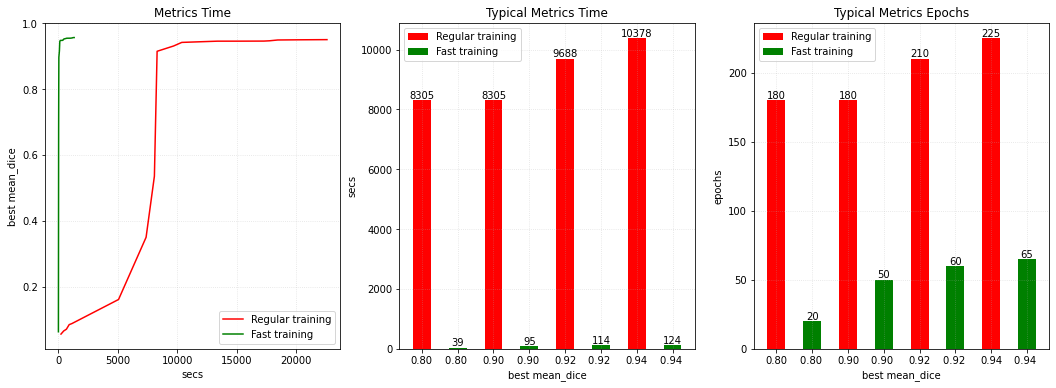

In [13]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


if not profiling:
    plt.figure("train", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Metrics Time")
    plt.xlabel("secs")
    plt.ylabel("best mean_dice")
    plt.plot(best[2], best[0], label="Regular training", color="red")
    plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 3, 2)
    plt.title("Typical Metrics Time")
    plt.xlabel("best mean_dice")
    plt.ylabel("secs")
    labels = ["0.80", "0.80 ", "0.90", "0.90 ", "0.92", "0.92 ", "0.94", "0.94 "]
    x_values = [0.8, 0.8, 0.9, 0.9, 0.92, 0.92, 0.94, 0.94]
    for i, (l, x) in enumerate(zip(labels, x_values)):
        value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
        color = "red" if i % 2 == 0 else "green"
        plt.bar(l, value, 0.5, label=get_label(i), color=color)
        plt.text(l, value, "%s" % value, ha="center", va="bottom")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")

    plt.subplot(1, 3, 3)
    plt.title("Typical Metrics Epochs")
    plt.xlabel("best mean_dice")
    plt.ylabel("epochs")
    for i, (l, x) in enumerate(zip(labels, x_values)):
        value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
        color = "red" if i % 2 == 0 else "green"
        plt.bar(l, value, 0.5, label=get_label(i), color=color)
        plt.text(l, value, "%s" % value, ha="center", va="bottom")
    plt.grid(alpha=0.4, linestyle=":")
    plt.legend(loc="best")
    plt.savefig("outputs/metric_time_epochs.png")

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)

[<sup id="fn1">1</sup>](#fn1-back) Acknowledgement: This usage is inspired by [Conditional with statement in Python](https://stackoverflow.com/a/68682614) by [Lucas Vasquez](https://stackoverflow.com/users/10712525/lucas-vazquez), used with adaptations under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/), accessed June 14, 2022.